# Importing Libraries

In [1]:
import pandas as pd
import numpy as np

import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Reading the data

In [2]:
# train
train = pd.read_csv(r"https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/final/X_train.csv")

# y_train
true_labels = pd.read_csv(r"https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/final/y_train.csv")

# test
test = pd.read_csv(r"https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/final/X_final.csv")

# y_test
test_labels = pd.read_csv(r"https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/final/y_final.csv")

In [3]:
train.head()

,review
0,"Shame, is a Swedish film in Swedish with Engli..."
1,I know it's rather unfair to comment on a movi...
2,"""Bread"" very sharply skewers the conventions o..."
3,After reading tons of good reviews about this ...
4,During the Civil war a wounded union soldier h...


### Fetching true labels for some observations in the train set

**We are fetching 10% of the true labels from the true labels**

In [4]:
size = int(0.10 * train.shape[0]) # percentage to fetch

index = np.random.choice(range(true_labels.shape[0]), size, replace = False)
index.sort()

In [5]:
target = []
for i in index:
    target.append(true_labels.iloc[i]['sentiment'])

In [6]:
train['target'] = None
train.loc[index,'target'] = target

In [7]:
train.head()

,review,target
0,"Shame, is a Swedish film in Swedish with Engli...",None
1,I know it's rather unfair to comment on a movi...,0
2,"""Bread"" very sharply skewers the conventions o...",None
3,After reading tons of good reviews about this ...,None
4,During the Civil war a wounded union soldier h...,None


In [8]:
# Sanity check

train['target'].value_counts()

target
1    2021
0    1979
Name: count, dtype: int64

---
# Data Preprocessing

### 1. Text Cleaning

**Removing any unnecessary characters, such as punctuation marks or special symbols, and convert the text to lowercase for consistency.**

In [9]:
def text_cleaning(text):
    clean_text = re.sub(r'[^\w\s]', '', text)  # Removing the punctuation
    clean_text = clean_text.lower()  # Converting lowercase
    return clean_text

### 2. Tokenization

**Spliting the text into individual words. This step is essential for further analysis and feature extraction.**

In [10]:
def tokenize(text):
    token = word_tokenize(text)
    return token

### 3. Stop Word Removal
**Removing common words that do not carry significant meaning, such as "and," "the," or "is." These words can be excluded from the analysis to reduce noise in the data.**

In [11]:
def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token not in stop_words]
    return filtered_tokens

### 4. Stemming and Lemmatization

**Stemming or Lemmatization: Reduce words to their base form to handle different variations of the same word. Stemming involves removing word suffixes, while lemmatization converts words to their dictionary form.**

In [12]:
def stemming(tokens):
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return stemmed_tokens

In [13]:
def lemmatization(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized_tokens

---
## Processing Train Dataset

**Here we will perform the preprocessing on train dataset. Once the preprocessing is done we will again split the datasets**

In [14]:
%%time

# Text Cleaning
train['review'] = train['review'].apply(lambda x: text_cleaning(x))

# Tokenizing
train['review'] = train['review'].apply(lambda x: tokenize(x))

# Stop Words Removal
train['review'] = train['review'].apply(lambda x: remove_stopwords(x))

# Stemming
train['review'] = train['review'].apply(lambda x: stemming(x))

# Lemmatization
train['review'] = train['review'].apply(lambda x: lemmatization(x))

# Joining the text
train['review'] = train['review'].apply(lambda x: ' '.join(x))

CPU times: total: 1min 58s
Wall time: 1min 58s


In [15]:
train.head()

,review,target
0,shame swedish film swedish english subtitl fil...,None
1,know rather unfair comment movi without see co...,0
2,bread sharpli skewer convent horror movi gener...,None
3,read ton good review movi decid take spin boug...,None
4,civil war wound union soldier hide isol confed...,None


### Feature Engineering Pipeline

In [16]:
pipeline = Pipeline([
    ('Count_Vectorizer', CountVectorizer(binary=True)), # For tokenization
    ('TF-iDF', TfidfTransformer()), # For converting into tdf-idf format
    ('TruncatedSVD', TruncatedSVD(n_components=300)) # Dimentinality Reduction
])

In [17]:
%%time

transformed_data = train['review'].values
transformed_data = pipeline.fit_transform(transformed_data, train['target'])

train_features = transformed_data

CPU times: total: 2min 8s
Wall time: 33.5 s


In [18]:
train_features.shape

(40000, 300)

In [19]:
print(train_features)

[[ 0.17843166 -0.04968433  0.0083688  ...  0.01156423  0.02857892
  -0.00205946]
 [ 0.21039223  0.09834249 -0.01554749 ... -0.02151784 -0.01605723
  -0.02135299]
 [ 0.1079967  -0.00587662 -0.01038427 ...  0.00707554 -0.00810538
  -0.00972366]
 ...
 [ 0.14725446  0.05581155  0.0149509  ... -0.00099401  0.03142661
   0.01816373]
 [ 0.14257894  0.0499227   0.01453348 ...  0.00038409  0.01219313
   0.01509306]
 [ 0.17956943  0.0370677   0.0520478  ... -0.00683968  0.00147853
   0.00333439]]


---
# Data Clustering


**Elbow method**

In [20]:
%%time
elbow = []
for i in [10, 30, 60, 80, 100, 200]:
    k = KMeans(n_clusters=i)
    k.fit(train_features)
    elbow.append(k.inertia_)

CPU times: total: 32min 53s
Wall time: 3min 2s


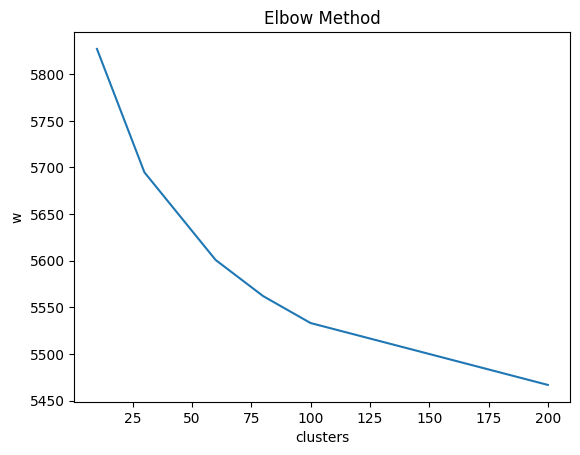

In [21]:
plt.plot([10, 30, 60, 80, 100, 200], elbow)
plt.title('Elbow Method')
plt.xlabel('clusters')
plt.ylabel('w')
plt.show()

**More the clusters we are using, the w value is getting lower. We will use 100 as our elbow point**

In [22]:
%%time

# Generating the clusters

num_clusters = 100
k_means = KMeans(n_clusters=num_clusters)
k_means.fit(train_features)

CPU times: total: 7min 30s
Wall time: 46.9 s


KMeans(n_clusters=100)

#### Clusters Visualization

In [23]:
%%time
pca = PCA(n_components=2)
k_means = KMeans(n_clusters= 100, max_iter = 250, random_state = 1999)

clusters = k_means.fit_transform(train_features)
labels = k_means.labels_

CPU times: total: 6min 31s
Wall time: 39 s


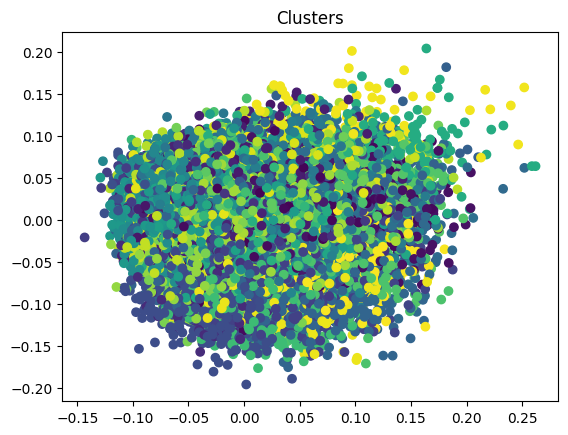

In [24]:
train_pca = pca.fit_transform(train_features)

plt.scatter(train_pca[:, 0], train_pca[:, 1], c=labels)
plt.title("Clusters")
plt.show()

In [25]:
# Checking the silhouette score

silhouette = silhouette_score(train_features, k_means.labels_)
print("Silhouette Score:", silhouette)

Silhouette Score: -0.07288811659104283


---
## Aggregating the target variable using avaliable 10% of our target values

In [26]:
labels = k_means.labels_
target = train['target']

##### Creating the dataframe which will have cluster labels for each instance

In [27]:
clustered_data = pd.DataFrame(labels, columns=['Cluster Label'])

clustered_data['target'] = target

In [28]:
clustered_data.head()

,Cluster Label,target
0,31,None
1,41,0
2,92,None
3,69,None
4,12,None


##### Aggregating the target for the samples for which target is not present

In [29]:
# Creating the dictionary for each cluster and its most occuring target value
cluster_mean_dict = clustered_data.groupby('Cluster Label')['target'].mean()

In [30]:
# Filling the values for None values in target variable
clustered_data.loc[ (clustered_data['target']).isna(), 'target']  = clustered_data[ (clustered_data['target'].isna())]['Cluster Label'].apply(lambda x: cluster_mean_dict[x])

In [31]:
# Converting the target into integer
clustered_data['target'] = clustered_data['target'].astype('float')
clustered_data['target'] = clustered_data['target'].round()
clustered_data.fillna(0, inplace = True)
clustered_data['target'] = clustered_data['target'].astype('int')

In [32]:
clustered_data.head()

,Cluster Label,target
0,31,1
1,41,0
2,92,0
3,69,0
4,12,1


In [33]:
clustered_data.isna().sum()

Cluster Label    0
target           0
dtype: int64

<Axes: ylabel='count'>

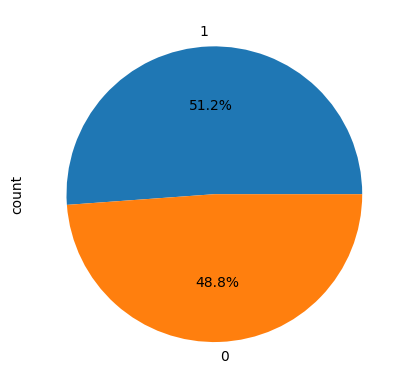

In [34]:
clustered_data.target.value_counts().plot.pie(autopct = '%1.1f%%')

**As we can see, the target variable is not majorly imbalanced. So we will use Accuracy as our scoring metrics.**

---
# Baseline Modeling

In [35]:
# Train test split

X_train, X_test, y_train, y_test = train_test_split(train_features, clustered_data['target'], test_size=0.2, random_state=1999)

In [36]:
# Logistic regression

model = LogisticRegression()

model.fit(X_train, y_train)

preds = model.predict(X_test)

print("Accuracy is:", accuracy_score(preds, y_test))

Accuracy is: 0.79275


In [37]:
print(classification_report(preds, y_test))

              precision    recall  f1-score   support

           0       0.77      0.80      0.78      3733
           1       0.82      0.79      0.80      4267

    accuracy                           0.79      8000
   macro avg       0.79      0.79      0.79      8000
weighted avg       0.79      0.79      0.79      8000



In [38]:
# LightGBM

model = LGBMClassifier(random_state=1999)

model.fit(X_train, y_train)

preds = model.predict(X_test)

print("Accuracy is:", accuracy_score(preds, y_test))

Accuracy is: 0.801875


In [40]:
%%time
# DecisionTreeClassifier

model = DecisionTreeClassifier()

model.fit(X_train, y_train)

preds = model.predict(X_test)

print("Accuracy is:", accuracy_score(preds, y_test))

Accuracy is: 0.695125
CPU times: total: 18 s
Wall time: 18 s


**All the basline models are giving almost same accuracy score. Now we develop a cross validation strategy to train and evaluate each model.**

---
# Cross Validation

In [41]:
def cross_val(clf, train, train_labels):
    N_splits = 5
    
    oofs = np.zeros(len(train))
    preds = np.zeros(len(test))
    
    target_col = train_labels
    
    folds = StratifiedKFold(n_splits = N_splits, shuffle = True,random_state = 1999)
    stratified_target = pd.qcut( train_labels, 10, labels=False, duplicates='drop')
    ""
    for index, (trn_idx, val_idx) in enumerate(folds.split(train, stratified_target)):
        print(f'\n================================Fold{index + 1}===================================')
        
        #### Train Set
        X_trn, y_trn = train[trn_idx], target_col.iloc[trn_idx]
        
        #### Validation Set
        X_val, y_val = train[val_idx], target_col.iloc[val_idx]

        
        ############ Fitting #############
        _ = clf.fit(X_trn, y_trn)
        
        ############ Predicting #############
        val_preds = clf.predict(X_val)

        
        acc = accuracy_score(y_val, val_preds)
        print(f'\n Accuracy for Validation set is : {acc}')

        
        oofs[val_idx] = val_preds
        
    total_error = accuracy_score(target_col, oofs)
    print(f'\nAccuracy for oofs is {total_error}')
    
    return oofs

**Here we will implement cross validation using 2 of our best models from baseline modelling.**

In [42]:
%%time
# Logistic regression
lr_oofs = cross_val(LogisticRegression(), train_features, clustered_data['target'])


================================Fold1===================================

 Accuracy for Validation set is : 0.78975

================================Fold2===================================

 Accuracy for Validation set is : 0.79175

================================Fold3===================================

 Accuracy for Validation set is : 0.791375

================================Fold4===================================

 Accuracy for Validation set is : 0.799875

================================Fold5===================================

 Accuracy for Validation set is : 0.799625

Accuracy for oofs is 0.794475
CPU times: total: 18.2 s
Wall time: 2.62 s


In [43]:
%%time
# LGBMClassifier
lgb_oofs = cross_val(LGBMClassifier(random_state = 1999), train_features, clustered_data['target'])


================================Fold1===================================

 Accuracy for Validation set is : 0.79875

================================Fold2===================================

 Accuracy for Validation set is : 0.804625

================================Fold3===================================

 Accuracy for Validation set is : 0.804125

================================Fold4===================================

 Accuracy for Validation set is : 0.807375

================================Fold5===================================

 Accuracy for Validation set is : 0.80875

Accuracy for oofs is 0.804725
CPU times: total: 2min 47s
Wall time: 16.7 s


---
# Hyperparameter Tuning

In [44]:
%%time
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 10],
    'tol' : [0.001, 0.1, 1],
    'max_iter' : [100, 1000, 2000]
}

# Grid search with cross-validation
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)


CPU times: total: 5min 46s
Wall time: 51.6 s


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 1, 10], 'max_iter': [100, 1000, 2000],
                         'penalty': ['l1', 'l2'], 'tol': [0.001, 0.1, 1]},
             scoring='accuracy')

In [45]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best Score:", best_score)

Best Hyperparameters: {'C': 10, 'max_iter': 100, 'penalty': 'l2', 'tol': 1}
Best Score: 0.7945625



**Getting cross validation results with runed model**

In [46]:
params = {'C': 10, 'max_iter': 100, 'penalty': 'l2', 'tol': 0.1}
model = LogisticRegression(**params)

In [47]:
%%time
lr_oofs = cross_val(model, train_features, clustered_data['target'])


================================Fold1===================================

 Accuracy for Validation set is : 0.78925

================================Fold2===================================

 Accuracy for Validation set is : 0.796625

================================Fold3===================================

 Accuracy for Validation set is : 0.792875

================================Fold4===================================

 Accuracy for Validation set is : 0.801875

================================Fold5===================================

 Accuracy for Validation set is : 0.80075

Accuracy for oofs is 0.796275
CPU times: total: 19.6 s
Wall time: 2.43 s


**The tuned model is slightly better than the baseline model with the same time complexity. SO will use the tuned model as our final model.**

In [48]:
# Selecting final model as our tuned logistic regression model
params = {'C': 10, 'max_iter': 100, 'penalty': 'l2', 'tol': 0.1}
model = LogisticRegression(**params)

---
# Processing Test Data

In [49]:
# Text Cleaning
test['review'] = test['review'].apply(lambda x: text_cleaning(x))

# Tokenizing
test['review'] = test['review'].apply(lambda x: tokenize(x))

# Stop Words Removal
test['review'] = test['review'].apply(lambda x: remove_stopwords(x))

# Stemming
test['review'] = test['review'].apply(lambda x: stemming(x))

# Lemmatization
test['review'] = test['review'].apply(lambda x: lemmatization(x))

# Joining the text
test['review'] = test['review'].apply(lambda x: ' '.join(x))

In [50]:
pipeline = Pipeline([
    ('Count_Vectorizer', CountVectorizer(binary=True)),
    ('TF-iDF', TfidfTransformer()),
    ('TruncatedSVD', TruncatedSVD(n_components=300))
])

In [51]:
%%time
transformed_data = test['review'].values
transformed_data = pipeline.fit_transform(transformed_data)

CPU times: total: 39.2 s
Wall time: 10.4 s


In [52]:
test_features = transformed_data

In [53]:
print(test_features)

[[ 0.13410878 -0.06109051  0.04340538 ... -0.00528821  0.00721845
  -0.00684185]
 [ 0.22615655 -0.05063965  0.03022034 ... -0.02256661 -0.01156926
   0.00530892]
 [ 0.16865621 -0.03085514  0.0403628  ...  0.02244963  0.00110279
  -0.02473486]
 ...
 [ 0.08443964  0.02596818 -0.03858186 ... -0.01140506 -0.00508317
  -0.00773005]
 [ 0.06270091  0.01188009 -0.0019176  ...  0.00150711 -0.00244351
  -0.02841841]
 [ 0.1631688   0.02715883 -0.02313738 ... -0.0100067   0.00062465
  -0.01202094]]


In [54]:
def cross_val_for_test(clf, train, train_labels, test):
    N_splits = 5
    
    oofs = np.zeros(len(train))
    preds = np.zeros(len(test))
    
    target_col = train_labels
    
    folds = StratifiedKFold(n_splits = N_splits, shuffle = True,random_state = 1999)
    stratified_target = pd.qcut( train_labels, 10, labels=False, duplicates='drop')
    ""
    for index, (trn_idx, val_idx) in enumerate(folds.split(train, stratified_target)):
        print(f'\n================================Fold{index + 1}===================================')
        
        #### Train Set
        X_trn, y_trn = train[trn_idx], target_col.iloc[trn_idx]
        
        #### Validation Set
        X_val, y_val = train[val_idx], target_col.iloc[val_idx]
        
        #### Test Set
        X_test = test
        
        ############ Fitting #############
        _ = clf.fit(X_trn, y_trn)
        
        ############ Predicting #############
        val_preds = clf.predict(X_val)
        test_preds = clf.predict(X_test)
        
        acc = accuracy_score(y_val, val_preds)
        print(f'\n Accuracy for Validation set is : {acc}')

        
        oofs[val_idx] = val_preds
        preds += test_preds / N_splits
        
    total_error = accuracy_score(target_col, oofs)
    print(f'\n\Accuracy for oofs is {total_error}')
    
    return oofs, preds

In [57]:
params = {'C': 10, 'max_iter': 100, 'penalty': 'l2', 'tol': 0.1}
final_model = LogisticRegression(**params)

In [58]:
%%time
lr_oofs, lr_preds = cross_val_for_test(final_model, train_features, clustered_data['target'], test_features)


================================Fold1===================================

 Accuracy for Validation set is : 0.78925

================================Fold2===================================

 Accuracy for Validation set is : 0.796625

================================Fold3===================================

 Accuracy for Validation set is : 0.792875

================================Fold4===================================

 Accuracy for Validation set is : 0.801875

================================Fold5===================================

 Accuracy for Validation set is : 0.80075

\Accuracy for oofs is 0.796275
CPU times: total: 18 s
Wall time: 2.43 s


In [59]:
lr_preds = lr_preds.astype('int')
print("Accuracy is:", accuracy_score(test_labels, lr_preds))

Accuracy is: 0.7697


In [60]:
print(classification_report(test_labels, lr_preds))

              precision    recall  f1-score   support

           0       0.76      0.79      0.77      5000
           1       0.78      0.75      0.76      5000

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000



## Conclusion

**Our NLP model achieved a test data accuracy of 77%. We applied standard data preprocessing techniques and utilized the elbow method to determine the optimal number of clusters. Aggregating missing target values within each cluster improved labeling accuracy. Through cross-validation and hyperparameter tuning, our model demonstrated a 77% accuracy on the test data, indicating successful generalization.**

## Explanation of solution 

**After loading the data, we applied standard techniques for preprocessing the test data to clean and process it. Once the preprocessing was completed on the training set, we employed feature engineering techniques and utilized dimensionality reduction to truncate the features.**

**Following feature engineering, we utilized the elbow method to determine the appropriate number of clusters. Upon completing the clustering process, we randomly selected 10% of the target values from y_train and employed mean aggregation to label the remaining 90% of the target values.**

**In the subsequent step, we tested multiple baseline models and opted to proceed with Logistic Regression. We implemented a cross-validation strategy and conducted hyperparameter tuning for the model.**

**Moving forward, we processed the test dataset and performed feature engineering on it. Using the implemented cross-validation strategy and tuned logistic regression model, we generated final predictions and achieved an accuracy of 77%.**